# sbpy.activity: dust

[sbpy.activity](https://sbpy.readthedocs.io/en/latest/sbpy/activity.html) has dust classes and fuctions for models of cometary dust comae.  Comet brightness can be estimated for observations of scattered light or themral emission.

## Light scattered by dust via Afρ

Light scattered by coma dust can be estimated via the cometary parameter Afρ.  For a circular aperture, the Αfρ quantity is the product of albedo, filling factor of dust in the aperture, and aperture radius.  It has units of length, is aperture-size independent for an idealized coma, and is proportional to mass loss rate under certain assumptions (see [A'Hearn et al. 1984 for details](https://ui.adsabs.harvard.edu/#abs/1984AJ.....89..579A/abstract)):

$$ Af\rho = \frac{(2 r_h \Delta)^2}{\rho}\frac{F_\lambda}{S_\lambda} $$

where $r_h$ is the heliocentric distance in au, $\Delta$ is the observer-comet distance in the same units as $\rho$, $F_\lambda$ is the flux desnity of the comet continuum, and $S_\lambda$ is the flux desnity of sunlight at 1 au in the same units as $F_\lambda$.

`sbpy` has a class that represents this parameter: `Afrho`.  With this quantity, we can estimate the brightness of a comet, under the assumptions of the Afρ model (isotropic coma in free expansion).

### Afρ is a quantity

`Afrho` is an `astropy` `Quantity` that has units of length.

In [1]:
import astropy.units as u
from sbpy.activity import Afrho

afrho = Afrho(100 * u.cm)
afrho = Afrho('100 cm')  # alternate initialization
afrho = Afrho(100, unit='cm')  # alternate initialization

print(afrho)

100.0 cm


In [2]:
# Arithmetic works as usual:
print(afrho * 2)

200.0 cm


In [3]:
# unit conversion, too
print(afrho.to('m'))

1.0 m


### Afρ from observed continuum flux density

`Afrho` can also be initialized from continuum flux densities.  Let's work with some photometry of comet 46P/Wirtanen by [Farnham et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998A&A...335L..50F/abstract).  The following observations were taken through the IHW blue continuum filter (λ=4845 Å).

In [4]:
import numpy as np

# comet ephemeris as a dictionary:
eph = {
    'rh': [1.12, 1.14, 1.07, 1.49, 1.72] * u.au,
    'delta': [1.41, 1.60, 1.54, 1.96, 2.31] * u.au,
    'phase': [45, 38, 40, 31, 24] * u.deg
}

# observational data:
wave = 4845 * u.AA
rho = 10**np.array((4.29, 4.64, 4.49, 5.03, 4.96)) * u.km
fluxd = 10**np.array((-13.74, -13.84, -13.48, -14.11, -14.30)) * u.erg / (u.cm**2 * u.s * u.AA)

afrho = Afrho.from_fluxd(wave, fluxd, rho, eph)
print(afrho)

[ 105.8130834    50.08581756  132.27388103   28.0898732    39.44082157] cm


Compare with the Farnham et al. values:

In [5]:
f98 = 10**np.array((2.05, 1.71, 2.14, 1.47, 1.61)) * u.cm
print('Mean percent difference: {:.1%}'.format(np.mean(np.abs(afrho - f98) / f98)))

Mean percent difference: 4.0%


### Afρ and sbpy's solar spectrum

The few percent difference is due to the assumed solar flux density.  We asked for the conversion at a specific wavelength, but the observation was through a filter with a specific width.  With the `spectroscopy` module we can show the solar flux density used:

In [6]:
from sbpy.spectroscopy.sun import default_sun
sun = default_sun.get()
print(sun(wave, unit=fluxd.unit))

196.89999999999878 erg / (Angstrom cm2 s)


But rather than having `sbpy` compute the solar flux density at 1 au, we can pass the precomputed value for this filter from [A'Hearn et al. 1995](https://ui.adsabs.harvard.edu/#abs/1995Icar..118..223A/abstract):

In [7]:
S = 189.7 * u.erg / (u.cm**2 * u.s * u.AA)
afrho = Afrho.from_fluxd(None, fluxd, rho, eph, S=S)
print('Mean percent difference: {:.1%}'.format(np.mean(np.abs(afrho - f98) / f98)))

Mean percent difference: 1.1%


In the future, we will be able to provide the filter transmission and have `sbpy` automatically compute the mean solar flux density in the filter.

## Dust thermal emission via εfρ

Dust can also be modeled with εfρ, a thermal emission corollary to Afρ ([Kelley et al. 2013](https://ui.adsabs.harvard.edu/#abs/2013Icar..225..475K/abstract)).  Albedo is replaced with emissivity, and the solar spectrum with the Planck function.  It is an approximation to the thermal emission from a comet that can be useful for observation planning and making comet-to-comet comparisions:

$$ \epsilon f \rho = \frac{F_\lambda}{\pi \rho B_\lambda(T_c)} $$

where $B_\lambda(T_c)$ is the Planck function evaluated at the apparent continuum temperature $T_c$.  The parameter is has units of length and is included in sbpy as the `Efrho` class.

The continuum temperature is parameterized with respect to the temperature of an isothermal blackbody sphere in LTE:

$$ T_{scale} = \frac{T_c}{278\,r_h^{-0.5}} $$

Plot a model spectrum of comet 46P/Wirtanen in December 2018 from 0.3 to 30 μm, varying the contintuum temperature:

<IPython.core.display.Javascript object>


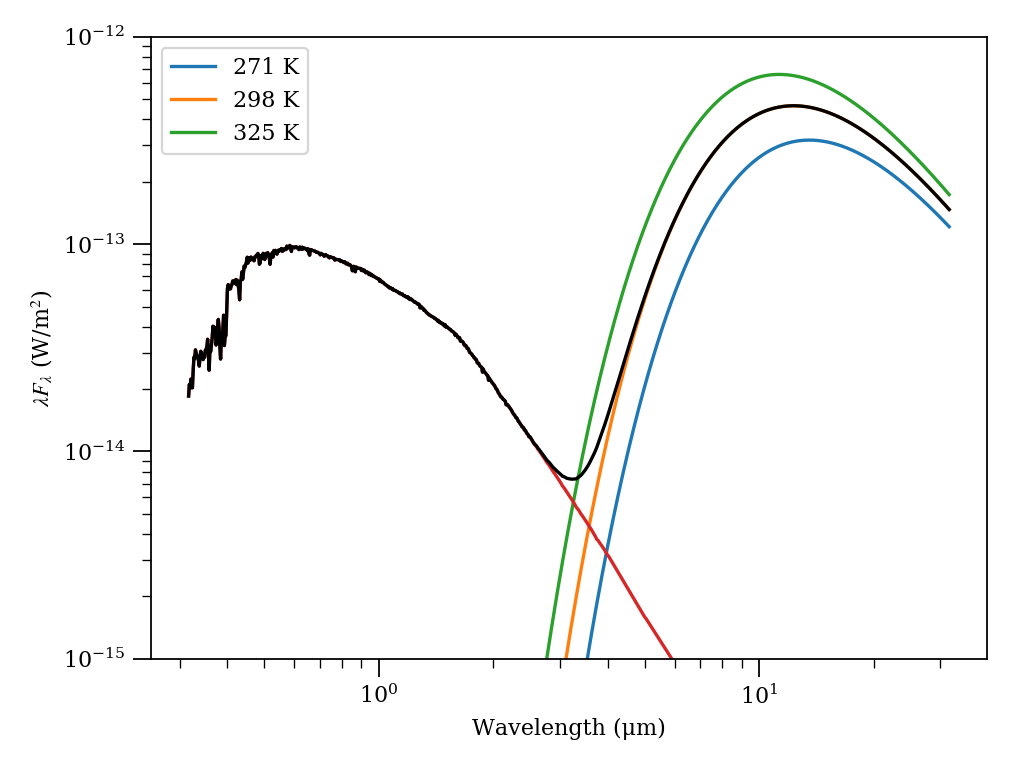

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from sbpy.activity import Afrho, Efrho
from sbpy.spectroscopy.sun import default_sun
%matplotlib notebook

afrho = Afrho(100 * u.cm)
efrho = Efrho(afrho * 3.5)

# comet 46P/Wirtanen on 13 Dec 2018 as observed by Earth
eph = {
    'rh': 1.055 * u.au,
    'delta': 0.080 * u.au,
    'phase': 27 * u.deg
}

wave = np.logspace(-0.5, 1.5, 1000) * u.um
rho = 1 * u.arcsec

fsca = afrho.fluxd(wave, rho, eph)
fth = efrho.fluxd(wave, rho, eph, Tscale=1.1)
ftot = fsca + fth

fig = plt.figure(1)
fig.clear()
ax = fig.add_subplot(111)

for Tscale in [1.0, 1.1, 1.2]:
    fth = efrho.fluxd(wave, rho, eph, Tscale=Tscale)
    T = Tscale * 278 * u.K / np.sqrt(eph['rh'] / u.au)
    ax.plot(wave, wave * fth, label="{:.0f}".format(T))
    
ax.plot(wave, wave * fsca)
ax.plot(wave, wave * ftot, color='k')
plt.setp(ax, xlabel='Wavelength (μm)', xscale='log',
         ylabel='$\lambda F_\lambda$ (W/m$^2$)', ylim=[1e-15, 1e-12], yscale='log')
ax.legend()
plt.tight_layout()